# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [2]:
import pandas as pd

#Import all the required libraries and functions
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from warnings import filterwarnings 
filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, ConfusionMatrixDisplay \
, classification_report, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree, export_graphviz
import graphviz
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance

In [3]:
# df = pd.read_csv('data/bank-additional/bank-additional-full.csv', sep = ';')
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [4]:
df.shape  #(41188, 21)
df['y'].value_counts()

y
no     36548
yes     4640
Name: count, dtype: int64

In [5]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [ ]:
#Not using this for the final run with all the data

# #Since the full data set is too big, let's start with a small subset:

# # # load the Bank marketing data from https://archive.ics.uci.edu/dataset/222/bank+marketing
# # df = pd.read_csv('data/bank.csv', sep=';')
# # df#.shape #= (4521, 17)
# df = df.sample(frac=.1, random_state=42)
# df.shape  #(4119, 21)

### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [6]:
df['contact'].value_counts()

contact
cellular     26144
telephone    15044
Name: count, dtype: int64

In [7]:
#dropping col contact as it looks useless for prediction. Could be dropped in future runs.
# df = df.drop(columns='contact', axis=1)

In [8]:
#Check for duplicates
df.duplicated().sum()

12

In [9]:
#remove duplicates
df = df.drop_duplicates()
df.shape

(41176, 20)

In [10]:
#Prepare X and y for data analyses
X = df.drop(columns='y', axis=1)
y = np.where(df['y'] == 'yes', 1, 0)

In [11]:
#Check the spread of data in y
pd.DataFrame(y).value_counts()

0    36537
1     4639
Name: count, dtype: int64

In [12]:
#get the Non-Numeric / Categorical columns in a df:
cols = X.columns
num_cols = X._get_numeric_data().columns
num_cols
catg_cols = list(set(cols) - set(num_cols))
print (catg_cols)

['education', 'poutcome', 'day_of_week', 'default', 'month', 'marital', 'housing', 'loan', 'job']


In [13]:
#Print the numeric columns
num_cols

Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'],
      dtype='object')

In [ ]:
# #get the NaN value count for all the columns
# for col in df.columns:
#     print(f'{col} NaN count: {df[col].isna().sum()}')  #No Nans (also mentioned in the page about the data!!!)

In [14]:
for col in X.columns:
    if col in (catg_cols):
                print(f'{col} unique values: {df[col].value_counts()}')

job unique values: job
admin.           10419
blue-collar       9253
technician        6739
services          3967
management        2924
retired           1718
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: count, dtype: int64
marital unique values: marital
married     24921
single      11564
divorced     4611
unknown        80
Name: count, dtype: int64
education unique values: education
university.degree      12164
high.school             9512
basic.9y                6045
professional.course     5240
basic.4y                4176
basic.6y                2291
unknown                 1730
illiterate                18
Name: count, dtype: int64
default unique values: default
no         32577
unknown     8596
yes            3
Name: count, dtype: int64
housing unique values: housing
yes        21571
no         18615
unknown      990
Name: count, dtype: int64
loan unique values: loan
no         3

In [ ]:
#DATA ANALYSIS
#Some of the cols like education, day_of_Week may be amenable to Ordinal encoding. But for simplicity we could 
# columns like day_of_Week; and then onehotencode education and other categorical variables.

In [15]:
#Future -- drop col (contact) day_of_week as data seems equally distributed (and to reduce cols in encoding)
# df = df.drop(columns='day_of_week', axis=1)

In [16]:
#check for collinearity
df.corr(numeric_only=True)

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
age,1.000000,-0.000808,0.004622,-0.034381,0.024379,-0.000242,0.001009,0.129075,0.010852,-0.017607
duration,-0.000808,1.000000,-0.071765,-0.047556,0.020600,-0.027941,0.005303,-0.008126,-0.032861,-0.044672
campaign,0.004622,-0.071765,1.000000,0.052606,-0.079182,0.150786,0.127826,-0.013657,0.135169,0.144129
pdays,-0.034381,-0.047556,0.052606,1.000000,-0.587508,0.271063,0.078920,-0.091374,0.296946,0.372659
previous,0.024379,0.020600,-0.079182,-0.587508,1.000000,-0.420587,-0.203197,-0.050929,-0.454571,-0.501411
emp.var.rate,-0.000242,-0.027941,0.150786,0.271063,-0.420587,1.000000,0.775293,0.196257,0.972244,0.906949
cons.price.idx,0.001009,0.005303,0.127826,0.078920,-0.203197,0.775293,1.000000,0.059170,0.688180,0.521945
cons.conf.idx,0.129075,-0.008126,-0.013657,-0.091374,-0.050929,0.196257,0.059170,1.000000,0.277864,0.100679
euribor3m,0.010852,-0.032861,0.135169,0.296946,-0.454571,0.972244,0.688180,0.277864,1.000000,0.945146
nr.employed,-0.017607,-0.044672,0.144129,0.372659,-0.501411,0.906949,0.521945,0.100679,0.945146,1.000000


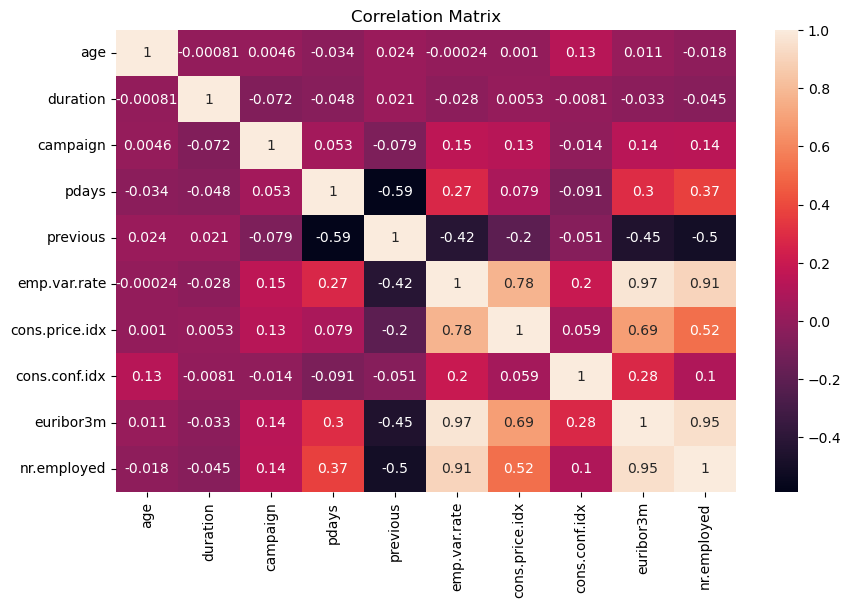

In [17]:
#visualize the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True)
plt.title('Correlation Matrix')
plt.show()

In [121]:
# p is strongly correlated with count(q,r,s,..)
# nr.employed ~ 3
# euribor3m ~ 2.7
# emp.var.rate ~ 2.7

# # Future -- drop nr.employed and euribor3m; keeping emp.var.rate and cons.conf.idx
# df = df.drop(columns='nr.employed', axis=1)
# df = df.drop(columns='euribor3m', axis=1)

In [18]:
df.pdays.value_counts(normalize=True) # > 96%

pdays
999    0.963207
3      0.010662
6      0.010006
4      0.002866
9      0.001554
2      0.001481
7      0.001457
12     0.001409
10     0.001263
5      0.001117
13     0.000874
11     0.000680
1      0.000631
15     0.000583
14     0.000486
8      0.000437
0      0.000364
16     0.000267
17     0.000194
18     0.000170
22     0.000073
19     0.000073
21     0.000049
25     0.000024
26     0.000024
27     0.000024
20     0.000024
Name: proportion, dtype: float64

In [123]:
#Future -- 96% of pdays is set to 999. So dropp that field also.
# df = df.drop(columns='pdays', axis=1)

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [ ]:
#The Business objective of the task is to help the Portugese bank optimize their marketing efforts by predicting
# which customers will subscribe to a term deposit and which ones won't do so.

In [ ]:
#This can be accomplished by creating a model that predicts which customers will subscribe to the term deposit 
# based on other existing data about the Customer.

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [20]:
#Preprocess the data. OneHotEncode all categorical columns, and scale the rest of the columns (numerical).
preprocessor = ''

preprocessor = make_column_transformer((OneHotEncoder(drop = 'if_binary', sparse_output=False), catg_cols), 
                                     remainder = StandardScaler())

pipeline = make_pipeline(
    preprocessor,
    LogisticRegression(random_state=42)
)

In [21]:
#Transform X to get a OneHotEncoded and Scaled data set
X_transformed = preprocessor.fit_transform(X)
X_transformed
# preprocessor.get_feature_names_out()

array([[ 1.        ,  0.        ,  0.        , ...,  0.88656813,
         0.71246263,  0.33169507],
       [ 0.        ,  0.        ,  0.        , ...,  0.88656813,
         0.71246263,  0.33169507],
       [ 0.        ,  0.        ,  0.        , ...,  0.88656813,
         0.71246263,  0.33169507],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -2.22505906,
        -1.49519696, -2.81568858],
       [ 0.        ,  0.        ,  0.        , ..., -2.22505906,
        -1.49519696, -2.81568858],
       [ 0.        ,  0.        ,  0.        , ..., -2.22505906,
        -1.49519696, -2.81568858]])

In [22]:
#Put X_transformed into a DataFrame
X_new = pd.DataFrame(X_transformed, columns=preprocessor.get_feature_names_out())
X_new #41176 rows × 61 columns

,onehotencoder__education_basic.4y,onehotencoder__education_basic.6y,onehotencoder__education_basic.9y,onehotencoder__education_high.school,onehotencoder__education_illiterate,onehotencoder__education_professional.course,onehotencoder__education_university.degree,onehotencoder__education_unknown,onehotencoder__poutcome_failure,onehotencoder__poutcome_nonexistent,...,remainder__age,remainder__duration,remainder__campaign,remainder__pdays,remainder__previous,remainder__emp.var.rate,remainder__cons.price.idx,remainder__cons.conf.idx,remainder__euribor3m,remainder__nr.employed
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.533143,0.010352,-0.565963,0.195443,-0.349551,0.648101,0.722628,0.886568,0.712463,0.331695
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.629107,-0.421577,-0.565963,0.195443,-0.349551,0.648101,0.722628,0.886568,0.712463,0.331695
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-0.290177,-0.124626,-0.565963,0.195443,-0.349551,0.648101,0.722628,0.886568,0.712463,0.331695
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-0.002284,-0.413864,-0.565963,0.195443,-0.349551,0.648101,0.722628,0.886568,0.712463,0.331695
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.533143,0.187751,-0.565963,0.195443,-0.349551,0.648101,0.722628,0.886568,0.712463,0.331695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41171,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,3.164534,0.291876,-0.565963,0.195443,-0.349551,-0.752402,2.058076,-2.225059,-1.495197,-2.815689
41172,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.573501,0.480845,-0.565963,0.195443,-0.349551,-0.752402,2.058076,-2.225059,-1.495197,-2.815689
41173,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.533143,-0.267317,-0.204990,0.195443,-0.349551,-0.752402,2.058076,-2.225059,-1.495197,-2.815689
41174,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.381573,0.708379,-0.565963,0.195443,-0.349551,-0.752402,2.058076,-2.225059,-1.495197,-2.815689


In [128]:
X_new.describe()

,onehotencoder__job_admin.,onehotencoder__job_blue-collar,onehotencoder__job_entrepreneur,onehotencoder__job_housemaid,onehotencoder__job_management,onehotencoder__job_retired,onehotencoder__job_self-employed,onehotencoder__job_services,onehotencoder__job_student,onehotencoder__job_technician,...,remainder__age,remainder__duration,remainder__campaign,remainder__pdays,remainder__previous,remainder__emp.var.rate,remainder__cons.price.idx,remainder__cons.conf.idx,remainder__euribor3m,remainder__nr.employed
count,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,...,4.117600e+04,4.117600e+04,4.117600e+04,4.117600e+04,4.117600e+04,4.117600e+04,4.117600e+04,4.117600e+04,4.117600e+04,4.117600e+04
mean,0.253036,0.224718,0.035360,0.025743,0.071012,0.041723,0.034510,0.096343,0.021250,0.163663,...,1.001724e-16,9.318367e-17,3.727347e-17,-1.090594e-16,6.902494e-18,4.141496e-17,2.599755e-14,-7.178594e-17,2.250213e-16,4.638476e-15
std,0.434757,0.417402,0.184691,0.158370,0.256848,0.199959,0.182538,0.295064,0.144219,0.369974,...,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-2.209460e+00,-9.961961e-01,-5.659633e-01,-5.148665e+00,-3.495514e-01,-2.216565e+00,-2.374990e+00,-2.225059e+00,-1.722363e+00,-2.815689e+00
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-7.699975e-01,-6.028326e-01,-5.659633e-01,1.954435e-01,-3.495514e-01,-1.198017e+00,-8.650522e-01,-4.747688e-01,-1.313003e+00,-9.402687e-01
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.942124e-01,-3.020253e-01,-2.049895e-01,1.954435e-01,-3.495514e-01,6.481012e-01,2.993617e-01,-2.802921e-01,7.124626e-01,3.316951e-01
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,6.694654e-01,2.340288e-01,1.559842e-01,1.954435e-01,-3.495514e-01,8.390789e-01,7.226279e-01,8.865681e-01,7.724252e-01,8.451864e-01
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,5.563639e+00,1.797009e+01,1.928759e+01,1.954435e-01,1.379305e+01,8.390789e-01,2.058076e+00,2.939378e+00,8.208565e-01,8.451864e-01


### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, random_state = 42, )

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [130]:
#Create a baseline
(df['y']=='no').sum() #3636
(df['y']=='yes').sum() #483
Baseline = (df['y']=='no').sum() / ((df['y']=='yes').sum() + (df['y']=='no').sum())
Baseline # 0.8827385287691187  
#If you guessed No in all cases, you would be correct 88.7% of the time!

0.8873372838546726

In [131]:
# #Code from documenation. Baseline creation using DummyClassifier
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X, y)
DummyClassifier(strategy='most_frequent')
dummy_clf.predict(X)
dummy_clf.score(X, y)  #0.8873372838546726  #SAME AS ABOVE

0.8873372838546726

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [132]:
%time
lgr = LogisticRegression().fit(X_train, y_train)   #0ns

CPU times: total: 0 ns
Wall time: 0 ns


In [ ]:
# # Evaluate the pipeline using cross-validation
# cv_scores = cross_val_score(pipeline, X, y, cv=5)
# cv_scores

# # # Calculate the average accuracy across the cross-validation folds
# # average_accuracy = cv_scores.mean()
# # print(f"Average accuracy: {average_accuracy:.2f}")

### Problem 9: Score the Model

What is the accuracy of your model?

In [133]:
lgr_train_Acc= lgr.score(X_train, y_train)  
lgr_test_Acc=lgr.score(X_test, y_test)  
lgr_train_Acc, lgr_test_Acc      

(0.9130237678906806, 0.9059646395958811)

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [134]:
%time 
knn = KNeighborsClassifier().fit(X_train, y_train)  #0ns

CPU times: total: 0 ns
Wall time: 0 ns


In [135]:
knn_train_Acc= knn.score(X_train, y_train)   
knn_test_Acc=knn.score(X_test, y_test)   
knn_train_Acc, knn_test_Acc   

(0.9281782267987825, 0.9016903050320575)

In [136]:
%time
dtc = DecisionTreeClassifier().fit(X_train, y_train)  # 0ns

CPU times: total: 0 ns
Wall time: 0 ns


In [137]:
dtc_train_Acc= dtc.score(X_train, y_train)   
dtc_test_Acc=dtc.score(X_test, y_test)  
dtc_train_Acc, dtc_test_Acc   

(1.0, 0.8873129978628327)

In [138]:
#Decision tree might be overfit as the Training accuracy = 1.0
dtc.get_depth()  #30

30

In [139]:
%time
svc = SVC().fit(X_train, y_train)  #0ns

CPU times: total: 0 ns
Wall time: 0 ns


In [140]:
svc_train_Acc= svc.score(X_train, y_train)  
svc_test_Acc=svc.score(X_test, y_test)  
svc_train_Acc, svc_test_Acc   

(0.9235800790104268, 0.9076160870409947)

In [141]:
scores = {
    'model': ['LogisticRegression', 'KNeighborsClassifier', 'DecisionTreeClassifier', 'SVC'],
    'Train Time': [0, 0, 0, 0],
    'Train Accuracy': [lgr_train_Acc, knn_train_Acc, dtc_train_Acc, svc_train_Acc],
    'Test Accuracy': [lgr_test_Acc, knn_test_Acc, dtc_test_Acc, svc_test_Acc],
}

#load data into a DataFrame object:
scores_df = pd.DataFrame(scores)

print(scores_df) 

# Earlier results with with 10% of the data
#                     model  Train Time  Train Accuracy  Test Accuracy
# 0      LogisticRegression           0        0.922305       0.897087
# 1    KNeighborsClassifier           0        0.934283       0.882524
# 2  DecisionTreeClassifier           0        1.000000       0.883495
# 3                     SVC           0        0.935902       0.890291

                    model  Train Time  Train Accuracy  Test Accuracy
0      LogisticRegression           0        0.913024       0.905965
1    KNeighborsClassifier           0        0.928178       0.901690
2  DecisionTreeClassifier           0        1.000000       0.887313
3                     SVC           0        0.923580       0.907616


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [ ]:
#  LogisticRegression

In [155]:
%%time 
# lgr -- Initialize the model
lgr_grid = LogisticRegression()

# hyperparameters to tune
params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],   #l1 penalty works only for liblinear and saga and not for the other solvers.
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

# Use GridSearchCV to find the best hyperparameters using cross-validation
grid_search = GridSearchCV(lgr_grid, params, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Display best hyperparameters and cross-validation score
print("Best hyperparameters:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

# Use the best model for subsequent steps
model = grid_search.best_estimator_

# Same results when GridSearch run with 10% of the data and all data
# Best hyperparameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
# Best cross-validation accuracy: 0.9184193272594714   (0.9125379615253308 -- for all data)
# CPU times: total: 1min 58s
# Wall time: 1min 21s

Best hyperparameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation accuracy: 0.9125379562827505
CPU times: total: 7min 33s
Wall time: 7min 38s


In [277]:
#save for future use
grid_search_lgr = grid_search

Accuracy: 0.90625607149796

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95      9094
           1       0.66      0.41      0.50      1200

    accuracy                           0.91     10294
   macro avg       0.79      0.69      0.73     10294
weighted avg       0.89      0.91      0.90     10294


Confusion Matrix:
 [[8843  251]
 [ 714  486]]


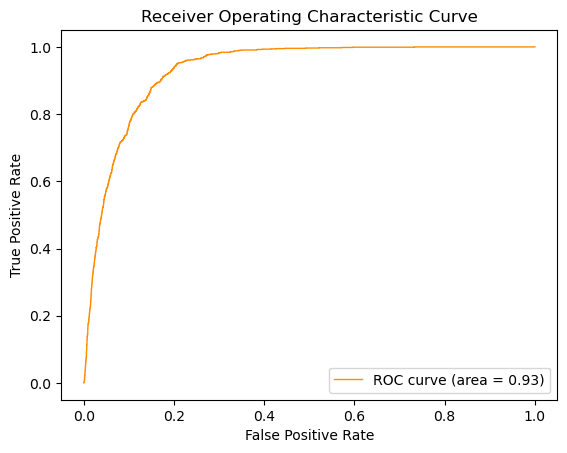

In [156]:
#Model evaluation
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()

In [289]:
model = grid_search_lgr.best_estimator_
t=pd.DataFrame()
t['coeff'] = pd.DataFrame(model.coef_.reshape(-1))
t['feature_names'] = model.feature_names_in_
t.set_index('feature_names', inplace=True)
t

,coeff
feature_names,
onehotencoder__job_admin.,0.014668
onehotencoder__job_blue-collar,-0.187138
onehotencoder__job_entrepreneur,-0.231092
onehotencoder__job_housemaid,0.020591
onehotencoder__job_management,0.045697
...,...
remainder__emp.var.rate,-1.776440
remainder__cons.price.idx,0.675231
remainder__cons.conf.idx,0.025234


In [231]:
#sort the coeffs according the absolute values and plot
t = t.reindex(t['coeff'].abs().sort_values(ascending=False).index)

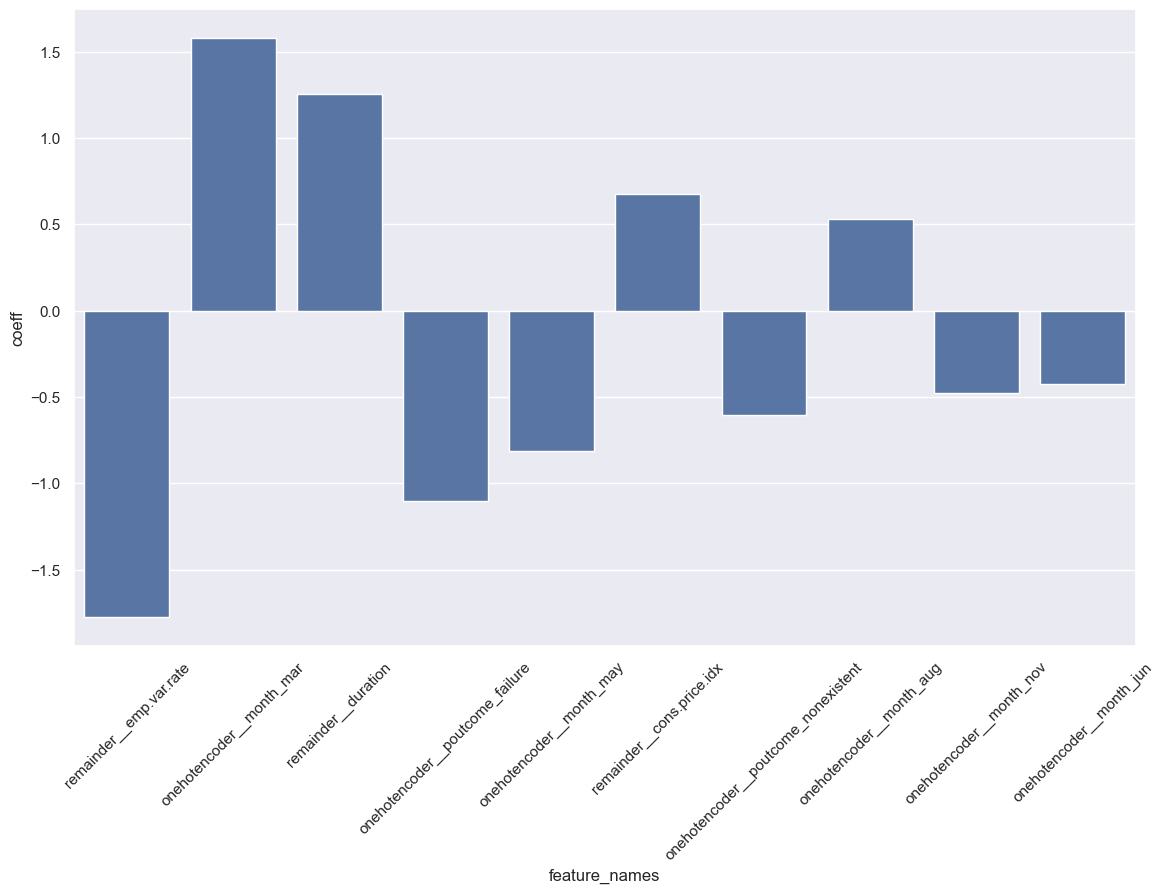

In [232]:
#Use seaborn to plot the top 10 co-efficient values
sns.set(rc={'figure.figsize':(13.7,8.27)})
sns.barplot(t[0:10], y='coeff', x='feature_names', orient='v')
plt.xticks(rotation=45)
plt.show()

In [268]:
#Create an XFull with X (transformed) and target y columns for analysis
Xfull = X
Xfull['y'] = y
Xfull

,age,job,marital,education,default,housing,loan,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,unknown,no,no,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,no,yes,no,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,no,no,no,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,no,no,yes,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1
41184,46,blue-collar,married,professional.course,no,no,no,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0
41185,56,retired,married,university.degree,no,yes,no,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0
41186,44,technician,married,professional.course,no,no,no,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1


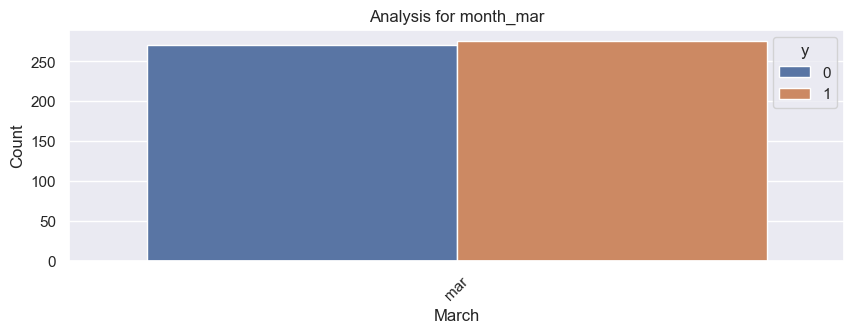

In [270]:
#do a count plot of Yes and No values for the Term Deposit against the categorical variables in the top 10 list
X_mar = Xfull.loc[(X['month'] == 'mar')]
plt.figure(figsize=(10, 3))
sns.countplot(data=X_mar, x='month', hue='y')
plt.xlabel('March')
plt.ylabel('Count')
plt.title(f'Analysis for month_mar')
plt.xticks(rotation=45)
plt.show()

#This shows that the month of March had high acceptance rate, while the acceptance rate was just 25% over all data

In [ ]:
# KNeighborsClassifier

In [278]:
%%time 
# knn -- Initialize the model
knn_grid = KNeighborsClassifier()

# hyperparameters to tune
params = {
#     'n_neighbors': range(1, len(y_test), 2),  # this was ok while testing. not good for all data.
    'n_neighbors': range(15, 35, 2),
    'weights': ['uniform', 'distance'],  
}

# Use GridSearchCV to find the best hyperparameters using cross-validation
grid_search = GridSearchCV(knn_grid, params, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Display best hyperparameters and cross-validation score
print("Best hyperparameters:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

# Use the best model for subsequent steps
model = grid_search.best_estimator_

#Results for all data
# Best hyperparameters: {'n_neighbors': 21, 'weights': 'uniform'}
# Best cross-validation accuracy: 0.9083284891889603
# CPU times: total: 15min 40s
# Wall time: 4min 52s

# Trial run Results for 10% of the data 
# Best hyperparameters: {'n_neighbors': 29, 'weights': 'distance'}
# Best cross-validation accuracy: 0.9132413337319634
# CPU times: total: 1h 45min 45s
# Wall time: 21min 39s

Best hyperparameters: {'n_neighbors': 21, 'weights': 'uniform'}
Best cross-validation accuracy: 0.9083284891889603
CPU times: total: 13min 16s
Wall time: 3min 36s


In [279]:
#save for future use
grid_search_knn = grid_search

Accuracy: 0.9037303283466097

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.98      0.95      9094
           1       0.66      0.36      0.47      1200

    accuracy                           0.90     10294
   macro avg       0.79      0.67      0.71     10294
weighted avg       0.89      0.90      0.89     10294


Confusion Matrix:
 [[8869  225]
 [ 766  434]]


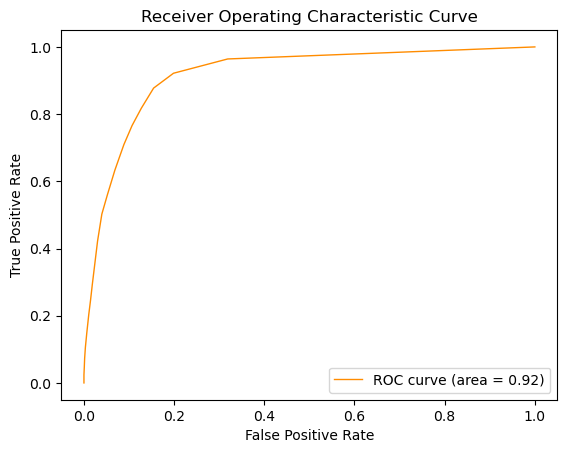

In [148]:
#Model evaluation
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()

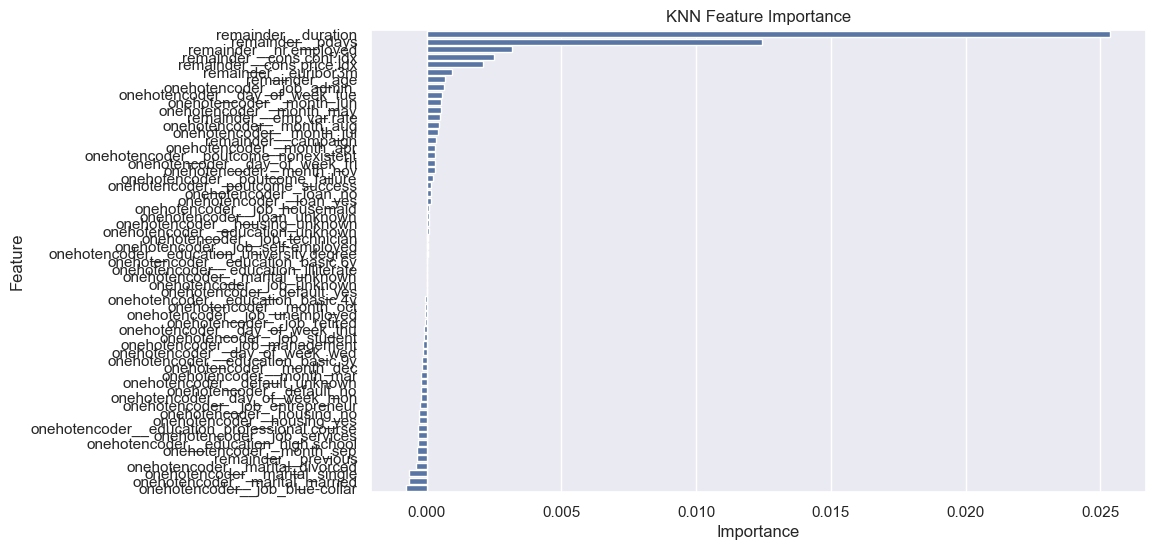

In [281]:
# permutation feature importance review
result = permutation_importance(grid_search_knn.best_estimator_, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# DataFrame with feature importances and feature names
knn_importances_df = pd.DataFrame({
    'Feature': grid_search_knn.best_estimator_.feature_names_in_,
    'Importance': result.importances_mean,
    'Importance Std': result.importances_std
}).sort_values(by='Importance', ascending=False)

# Plotting the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(data=knn_importances_df, x='Importance', y='Feature')
plt.title('KNN Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

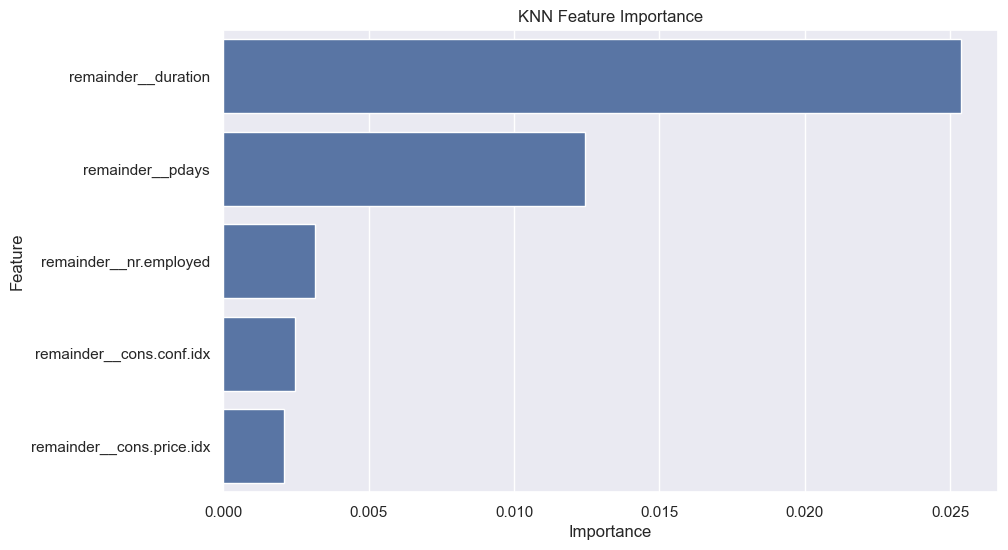

In [287]:
# Plotting the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(data=knn_importances_df.loc[(np.abs(knn_importances_df['Importance'])> .001)], x='Importance', y='Feature')
plt.title('KNN Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [ ]:
# DecisionTreeClassifier

In [292]:
%%time 
# dtc -- Initialize the model
dtc_grid = DecisionTreeClassifier()

# hyperparameters to tune
params = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [5,10,12],  
}

# Use GridSearchCV to find the best hyperparameters using cross-validation
grid_search = GridSearchCV(dtc_grid, params, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Display best hyperparameters and cross-validation score
print("Best hyperparameters:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

# Use the best model for subsequent steps
model = grid_search.best_estimator_

# results for both all of the data
# Best hyperparameters: {'criterion': 'gini', 'max_depth': 5}
# Best cross-validation accuracy: 0.9147075562780531
# CPU times: total: 16.3 s
# Wall time: 17.2 s

# results for both 10% of the data
# Best hyperparameters: {'criterion': 'entropy', 'max_depth': 5}
# Best cross-validation accuracy: 0.9135649583274326
# CPU times: total: 1.06 s
# Wall time: 1.06 s

Best hyperparameters: {'criterion': 'gini', 'max_depth': 5}
Best cross-validation accuracy: 0.9147075562780531
CPU times: total: 30.6 s
Wall time: 33 s


In [301]:
#save for future use
grid_search_dtc = grid_search
type(grid_search_dtc.best_estimator_)

sklearn.tree._classes.DecisionTreeClassifier

In [308]:
# EDisplay the decision tree
tree = export_text(grid_search_dtc.best_estimator_, feature_names=X_train.columns.tolist() )
print(tree)

|--- remainder__nr.employed <= -1.10
|   |--- remainder__duration <= -0.38
|   |   |--- remainder__duration <= -0.52
|   |   |   |--- remainder__pdays <= -5.13
|   |   |   |   |--- remainder__euribor3m <= -1.67
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- remainder__euribor3m >  -1.67
|   |   |   |   |   |--- class: 0
|   |   |   |--- remainder__pdays >  -5.13
|   |   |   |   |--- remainder__duration <= -0.70
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- remainder__duration >  -0.70
|   |   |   |   |   |--- class: 0
|   |   |--- remainder__duration >  -0.52
|   |   |   |--- remainder__pdays <= -5.08
|   |   |   |   |--- onehotencoder__day_of_week_mon <= 0.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- onehotencoder__day_of_week_mon >  0.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- remainder__pdays >  -5.08
|   |   |   |   |--- remainder__cons.conf.idx <= 2.28
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- remainder__cons.conf.idx >  2.28
|

In [ ]:
# export_graphviz(grid_search_dtc.best_estimator_, out_file="tree.dot", class_names=["0", "1"],feature_names=X_train.columns.tolist(), impurity=False, filled=True)

# with open("tree.dot") as f:
#     dot_graph = f.read()
# graphviz.Source(dot_graph)


# dot_data = export_graphviz(grid_search_dtc.best_estimator_, out_file=None, feature_names=X_train.columns.tolist(),  
#                            class_names=['no', 'yes'], filled=True, rounded=True, special_characters=True)
# # Render the dot file as a graph
# graph = graphviz.Source(dot_data)
# graph.render

# dot -Tpng graph > output.png

# # Render and save the graph to the specified path
# graph.render("../tree", format='pdf')

Accuracy: 0.9118904216048184

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95      9094
           1       0.67      0.48      0.56      1200

    accuracy                           0.91     10294
   macro avg       0.80      0.72      0.75     10294
weighted avg       0.90      0.91      0.91     10294


Confusion Matrix:
 [[8813  281]
 [ 626  574]]


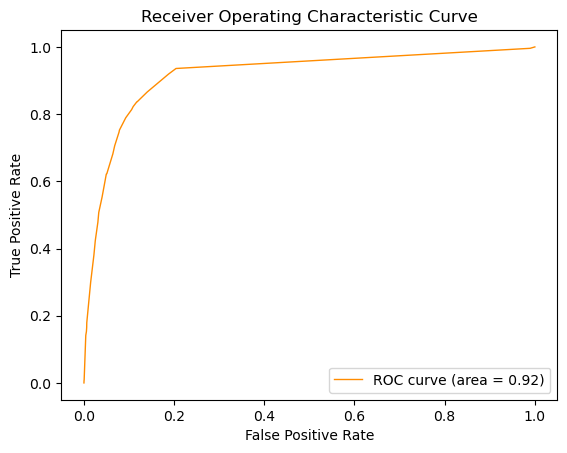

In [150]:
# Model evaluation
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Support Vector Machines 

In [151]:
%%time 
# SVC -- Initialize the model
svc_grid = SVC(probability=True)

# hyperparameters to tune
# params = {['rbf', 'poly', 'linear', 'sigmoid'], => Linear was best with smaller sample
#          'gamma': [0.1, 1.0, 10.0, 100.0],   
#          'C': [0.1, 1, 10, 100],  #
#          }
#For the whole data, we will use some of the parameters found by doing the Grid Search with 10% of the data
params = {'kernel': ['linear'],   #['rbf', 'poly', 'linear', 'sigmoid'], => Linear was best with smaller sample
         'gamma': [0.1, 0.2, 1.0],   
         'C': [0.1, 0.2, 1],  #
         }

# Use GridSearchCV to find the best hyperparameters using cross-validation
grid_search = GridSearchCV(svc_grid, param_grid=params, cv=5, scoring='accuracy').fit(X_train, y_train)

# Display best hyperparameters and cross-validation score
print("Best hyperparameters:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

# Use the best model for subsequent steps
model = grid_search.best_estimator_

#Best params for all data
# Best hyperparameters: {'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'}
# Best cross-validation accuracy: 0.9057378994951186
# CPU times: total: 1h 58min 4s
# Wall time: 2h 1min 8s

#Best values found with 10% of the data.
# Best hyperparameters: {'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'}
# Best cross-validation accuracy: 0.9148594567093097
# CPU times: total: 19min 41s
# Wall time: 20min 15s

Best hyperparameters: {'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'}
Best cross-validation accuracy: 0.9057378994951186
CPU times: total: 1h 58min 4s
Wall time: 2h 1min 8s


In [152]:
grid_search.cv_results_  #mean_fit_time 

{'mean_fit_time': array([170.5755199 , 197.16265974, 191.22484331, 137.56970153,
        138.81258826, 118.72224827, 157.80923409, 148.35573888,
        137.73270411]),
 'std_fit_time': array([36.58055654, 58.31447956, 73.58249992, 13.27569541,  4.03695292,
         1.18994991,  7.66771447, 13.42853692,  2.77123158]),
 'mean_score_time': array([3.18118482, 4.12050152, 3.31582313, 1.98121853, 1.90487819,
        1.75422015, 2.26930428, 1.54465375, 1.50788088]),
 'std_score_time': array([1.22194418, 2.13576098, 1.77637991, 0.34185914, 0.25607742,
        0.17313042, 0.9746037 , 0.19915122, 0.25538923]),
 'param_C': masked_array(data=[0.1, 0.1, 0.1, 0.2, 0.2, 0.2, 1, 1, 1],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_gamma': masked_array(data=[0.1, 0.2, 1.0, 0.1, 0.2, 1.0, 0.1, 0.2, 1.0],
              mask=[False, False, False, False, False, False, False, False,
       

Accuracy: 0.9015931610646979

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.98      0.95      9094
           1       0.65      0.33      0.44      1200

    accuracy                           0.90     10294
   macro avg       0.78      0.65      0.69     10294
weighted avg       0.89      0.90      0.89     10294


Confusion Matrix:
 [[8881  213]
 [ 800  400]]


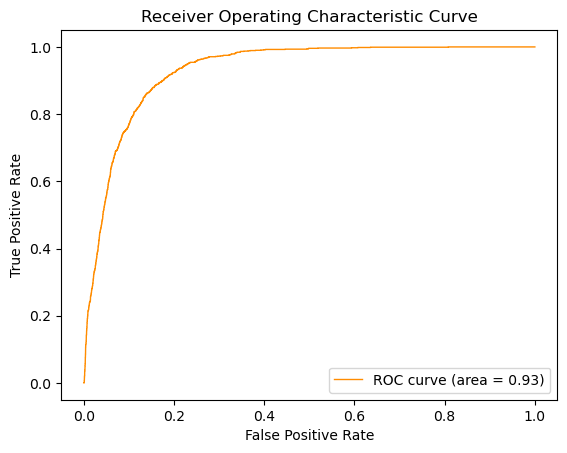

In [153]:
#Model evaluation
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()

In [291]:
# y_test.shape  #(10294,)

(10294,)

##### Questions